# VGG

This notebook visualize our trained VGG16 model.

In [1]:
import h5py
from matplotlib import pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from torchvision import models

## Step 1 - Config

First set the hyperparameters and other configurations.

In [2]:
# Dataset and model path
DATASET_PATH = "./datasets/Ra_128_indexed.h5"
DATASET_FAKE_PATH = "./datasets/CcGAN_SAGAN_dim_128_128_batchSizeG_64_batchSizeD_64_lrG_1e-04_lrD_1e-04_nIters_30000_nDsteps_4_soft_0.047_108.739_loss_hinge_seed_42_in_generate.h5"
# DATASET_FAKE_PATH = "./datasets/Ra_128_indexed.h5"
MODEL_DIR = "./models"
OUTPUT_DIR = "./outputs"
IMAGE_DIR = "./images"
# Env
SEED = 42
# Dataset
MIN_LABEL = 1.3
MAX_LABEL = 5.2
# Hyperparameters
NUM_EPOCHS = 200
LR = 1e-3
LR_WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2
BATCH_SIZE_TRAIN = 256
BATCH_SIZE_VAL = 10

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# Path
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR, exist_ok=True)
    print(f"Make new directory {MODEL_DIR}")
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR, exist_ok=True)
    print(f"Make new directory {OUTPUT_DIR}")
if not os.path.exists(IMAGE_DIR):
    os.makedirs(IMAGE_DIR, exist_ok=True)
    print(f"Make new directory {IMAGE_DIR}")
MODEL_PATH = f"{MODEL_DIR}/VGG16_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.pth"
OUTPUT_PATH = f"{OUTPUT_DIR}/VGG16_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.csv"
IMAGE_PATH = f"{IMAGE_DIR}/VGG16_test_size_{TEST_SIZE}_epoch_{NUM_EPOCHS}_batch_size_{BATCH_SIZE_TRAIN}_lr_{LR:.0e}_seed_{SEED}.png"

Device: cpu


Then load the pretrained model from `torchvision`.

In [3]:
# Pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Change the last layer to fit the regression task
vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=1)

# Choose to freeze the layers or not
for param in vgg16.features.parameters():
    param.requires_grad = False

# Move to the appropriate device
vgg16 = vgg16.to(device)

/opt/homebrew/Caskroom/miniconda/base/envs/2025-04-23_macOS/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniconda/base/envs/2025-04-23_macOS/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Step 2 - Load data

In this step we load the images and process them, the goal is to get `train_loader` and `val_loader` for training. After this step we will get:

1. `images_train` and `images_val` (4 dim tensor)
2. `labels_train` and `labels_val` (1 dim tensor)
3. `train_dataset` and `val_dataset` (dataset)
4. `train_loader` and `val_loader` (dataloader)

First we load the images, and normalize the pixel values.

In [4]:
# Load datasets
with h5py.File(DATASET_PATH, "r") as f:
    images = f["images"][:].astype(float)
    labels = f["labels"][:].astype(float)
N_all = len(images)
print("Images and labels loaded.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Load fake datasets
with h5py.File(DATASET_FAKE_PATH, "r") as f:
    images_fake = f["images"][:].astype(float)
    labels_fake = f["labels"][:].astype(float)
N_fake_all = len(images_fake)
print("Fake images and labels loaded.")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")

# Selection
indx = np.where((labels >= MIN_LABEL) * (labels < MAX_LABEL) == True)[0]
labels = labels[indx]
images = images[indx]
print(f"Select indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")
print("")

# Selection fake
indx_fake = np.where((labels_fake >= MIN_LABEL) * (labels_fake < MAX_LABEL) == True)[0]
labels_fake = labels_fake[indx_fake]
images_fake = images_fake[indx_fake]
print(f"Select fake indexes by MIN_LABEL = {MIN_LABEL} and MAX_LABEL = {MAX_LABEL}")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")
print("")

# To tensor
images = torch.from_numpy(images).permute(0, 3, 1, 2)
labels = torch.from_numpy(labels)
print("Transform `images` and `labels` to tensors.")
print(f"Images Shape: {images.shape}")
print(f"Labels Shape: {labels.shape}")

# Fake to tensor
images_fake = torch.from_numpy(images_fake).permute(0, 3, 1, 2)
labels_fake = torch.from_numpy(labels_fake)
print("Transform `images_fake` and `labels_fake` to tensors.")
print(f"Fake Images Shape: {images_fake.shape}")
print(f"Fake Labels Shape: {labels_fake.shape}")

Images and labels loaded.
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Fake images and labels loaded.
Fake Images Shape: (9192, 128, 128, 3)
Fake Labels Shape: (9192,)
Select indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Images Shape: (9192, 128, 128, 3)
Labels Shape: (9192,)

Select fake indexes by MIN_LABEL = 1.3 and MAX_LABEL = 5.2
Fake Images Shape: (9191, 128, 128, 3)
Fake Labels Shape: (9191,)

Transform `images` and `labels` to tensors.
Images Shape: torch.Size([9192, 3, 128, 128])
Labels Shape: torch.Size([9192])
Transform `images_fake` and `labels_fake` to tensors.
Fake Images Shape: torch.Size([9191, 3, 128, 128])
Fake Labels Shape: torch.Size([9191])


Then use `train_test_split` function to get data for training and validation.

In [5]:
# Train-test split
images_train, images_val, labels_train, labels_val = train_test_split(
    images, labels, test_size=TEST_SIZE, random_state=SEED
)

# Set fake as val
images_val = images_fake
labels_val = labels_fake

Implement images standardization and labels normalization.

In [6]:
# Image standardization
mean = images_train.mean(dim=[0, 2, 3], keepdim=True)
std = images_train.std(dim=[0, 2, 3], keepdim=True)
print(f"Mean of `images_train`: {mean}")
print(f"Std of `images_train`: {std}")
images_train = (images_train - mean) / std
images_val = (images_val - mean) / std

# Label normalization
labels_train = (labels_train - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)
labels_val = (labels_val - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)

print(f"Train test split with test size {TEST_SIZE}.")
print(f"Images (train) Shape: {images_train.shape}")
print(f"Images (val) Shape: {images_val.shape}")
print(f"Labels (train) Shape: {labels_train.shape}")
print(f"Labels (val) Shape: {labels_val.shape}")

Mean of `images_train`: tensor([[[[ 13.5371]],

         [[ 17.8462]],

         [[112.1119]]]], dtype=torch.float64)
Std of `images_train`: tensor([[[[18.5847]],

         [[20.2589]],

         [[41.6000]]]], dtype=torch.float64)
Train test split with test size 0.2.
Images (train) Shape: torch.Size([7353, 3, 128, 128])
Images (val) Shape: torch.Size([9191, 3, 128, 128])
Labels (train) Shape: torch.Size([7353])
Labels (val) Shape: torch.Size([9191])


Next, we should transform the data to tensors, combine `images` and `labels` to datasets and get dataloaders according to `BATCH_SIZE`.

In [7]:
# Change to tensor
images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
images_val_tensor = torch.tensor(images_val, dtype=torch.float32)
labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)
print(f"Shape of `images_train_tensor`: {images_train_tensor.shape}")
print(f"Shape of `labels_train_tensor`: {labels_train_tensor.shape}")
print(f"Shape of `images_val_tensor`: {images_val_tensor.shape}")
print(f"Shape of `labels_val_tensor`: {labels_val_tensor.shape}")

# Tensor's dataset
train_dataset = TensorDataset(images_train_tensor, labels_train_tensor)
val_dataset = TensorDataset(images_val_tensor, labels_val_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_TRAIN, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL)

/var/folders/j2/1t6mzhh53vb76rvvn6g_yhm80000gn/T/ipykernel_26623/1722485521.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_train_tensor = torch.tensor(images_train, dtype=torch.float32)
/var/folders/j2/1t6mzhh53vb76rvvn6g_yhm80000gn/T/ipykernel_26623/1722485521.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  images_val_tensor = torch.tensor(images_val, dtype=torch.float32)


Shape of `images_train_tensor`: torch.Size([7353, 3, 128, 128])
Shape of `labels_train_tensor`: torch.Size([7353, 1])
Shape of `images_val_tensor`: torch.Size([9191, 3, 128, 128])
Shape of `labels_val_tensor`: torch.Size([9191, 1])


/var/folders/j2/1t6mzhh53vb76rvvn6g_yhm80000gn/T/ipykernel_26623/1722485521.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_train_tensor = torch.tensor(labels_train, dtype=torch.float32).view(-1, 1)
/var/folders/j2/1t6mzhh53vb76rvvn6g_yhm80000gn/T/ipykernel_26623/1722485521.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_val_tensor = torch.tensor(labels_val, dtype=torch.float32).view(-1, 1)


## Step 3 - Load the model

To read the saved data, we can run the following codes:

In [8]:
# Load the trained model weights
vgg16.load_state_dict(torch.load(MODEL_PATH, map_location=device))
vgg16.eval()
print("Model loaded from", MODEL_PATH)

summary(vgg16, input_size=(3, 128, 128))

Model loaded from ./models/VGG16_test_size_0.2_epoch_200_batch_size_256_lr_1e-03_seed_42.pth
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
         MaxPool2d-5           [-1, 64, 64, 64]               0
            Conv2d-6          [-1, 128, 64, 64]          73,856
              ReLU-7          [-1, 128, 64, 64]               0
            Conv2d-8          [-1, 128, 64, 64]         147,584
              ReLU-9          [-1, 128, 64, 64]               0
        MaxPool2d-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
          

## Step 4 - Extract features

We extract the images' features from the second-to-last layer of the trained VGG16 net.

In [ ]:
# Get features
def get_fc2_features(model, batch_images):
    features = []
    def hook_fn(module, input, output):
        features.append(output)
    handle = model.classifier[3].register_forward_hook(hook_fn)
    model.eval()
    with torch.no_grad():
        _ = model(batch_images)
    handle.remove()
    return features[0]

# Get features
features_val = []
for _images, _ in val_loader:
    features_val.append(get_fc2_features(vgg16, _images.to(device)).cpu().detach().numpy())
features_val = np.concatenate(features_val, axis=0)

print(f"Shape of features of the images for validation: {features_val.shape}")

We use t-SNE algorithm to decrease the features' dimemsion to 2, and plot the 2-dimensional features with gradual colors.

[[ -419.17825    553.89014 ]
 [ -177.36572    650.239   ]
 [ -306.48697    614.7287  ]
 ...
 [-1054.0358      29.484306]
 [-1054.0358      29.484306]
 [ -112.97637   -717.4599  ]]


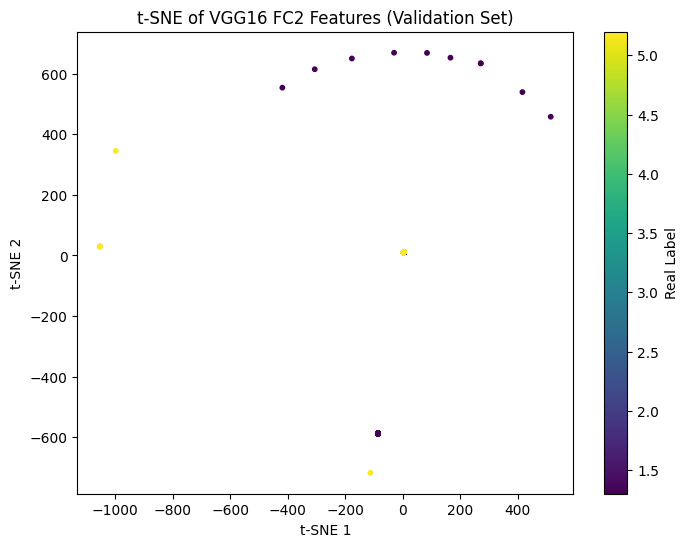

In [ ]:
# Turn to `numpy.array`
labels_val_real = labels_val.numpy()
labels_val_predicted = []
for _images_val_tensor, _labels_val_tensor in val_loader:
    preds = vgg16(_images_val_tensor.to(device)).cpu().detach().numpy()
    labels_val_predicted.append(preds)
labels_val_predicted = np.concatenate(labels_val_predicted, axis=0)

# Unnormalize labels
labels_val_real = labels_val_real * (MAX_LABEL - MIN_LABEL) + MIN_LABEL
labels_val_predicted = labels_val_predicted * (MAX_LABEL - MIN_LABEL) + MIN_LABEL

# Turn to `pandas.Series`
labels_val_real = pd.Series(labels_val_real)
labels_val_predicted = pd.Series(labels_val_predicted.flatten())
labels_val_diff = labels_val_predicted - labels_val_real

# t-SNE
tsne = TSNE(n_components=2, random_state=SEED)
reduced_tsne = tsne.fit_transform(features_val)
print(reduced_tsne)

# Plot 2-dim features
plt.figure(figsize=(8, 6))
plt.scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=labels_val_real, cmap='viridis', s=10)
plt.colorbar(label='Real Label')
plt.title('t-SNE of VGG16 FC2 Features (Validation Set)')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.savefig(IMAGE_PATH)
plt.show()

## Exceptional test

Let's see if the model works well.

      Real Labels  Predicted Labels      Diff      MAPE
0        1.300000          2.509999  1.209999  0.069232
1        1.300424          2.509999  1.209574  0.069862
2        1.300849          2.509999  1.209150  0.070491
3        1.301273          2.509999  1.208726  0.071120
4        1.301697          2.509999  1.208301  0.071749
...           ...               ...       ...       ...
9186     5.197878          2.509999 -2.687880  0.482889
9187     5.198303          2.509999 -2.688304  0.482850
9188     5.198727          2.509999 -2.688728  0.482810
9189     5.199151          2.509999 -2.689153  0.482771
9190     5.199576          2.510292 -2.689284  0.482788

[9191 rows x 4 columns]
MAPE: 0.6658359542776325


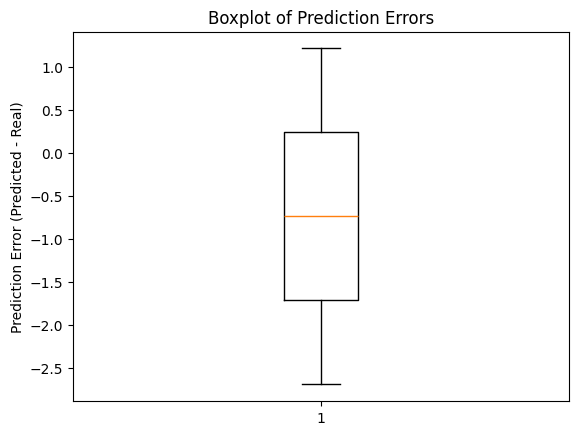

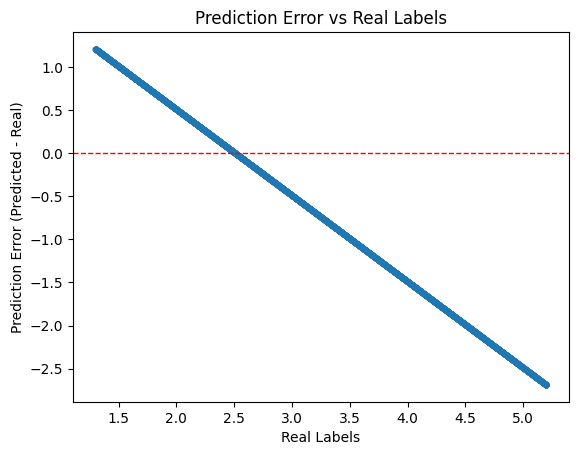

In [ ]:
# Make `pandas.DataFrame`
df = pd.DataFrame(
    {
        "Real Labels": labels_val_real,
        "Predicted Labels": labels_val_predicted,
        "Diff": labels_val_diff,
        "MAPE": 1 - np.abs(labels_val_diff) / labels_val_real
    }
)
df.to_csv(OUTPUT_PATH, index = False)
print(df)
print(f"MAPE: {df["MAPE"].mean()}")

# Boxplot of the differences
plt.boxplot(labels_val_diff)
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Boxplot of Prediction Errors")
plt.show()

# Plot the differences by the real labels.
plt.scatter(labels_val_real, labels_val_diff, s=10)
plt.xlabel("Real Labels")
plt.ylabel("Prediction Error (Predicted - Real)")
plt.title("Prediction Error vs Real Labels")
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.show()